In [36]:
import rioxarray as rio
import xarray as xr
import glob
import os
import numpy as np
import requests
import geopandas as gpd
from pathlib import Path
from datetime import datetime
from rasterio.enums import Resampling
%matplotlib inline

all_scenes_f_precip = Path('/scratch/waves/rhone-ecostress/rasters/chirps-clipped')
all_scenes_f_et = Path('/home/serdp/rhone/rhone-ecostress/rasters/eeflux/PDR')

all_precip_paths = list(all_scenes_f_precip.glob("*"))
all_pdr_et_paths = list(all_scenes_f_et.glob("*.tif"))

In [ ]:
# for some reason the fll value is not correct. this is the correct bad value to mask by
testf = all_precip_paths[0]
x = rio.open_rasterio(testf)
badvalue = np.unique(x.where(x != x._FillValue).sel(band=1))[0]

def chirps_path_date(path):
    _, _, year, month, day, _ = path.name.split(".")
    day = day.split("-")[0]
    return datetime(int(year), int(month), int(day))


def open_chirps(path):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = chirps_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension



### data is not tiled so not a good idea to use chunking
#https://github.com/pydata/xarray/issues/2314

import rasterio
with rasterio.open(testf) as src:
    print(src.profile)

len(all_precip_paths) * 41.7 / 10e3

%timeit open_chirps(testf)

all_daily_precip_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_chirps_daily.nc"

if Path(all_daily_precip_path).exists():
    
    all_chirps_arr = xr.open_dataarray(all_daily_precip_path)
else:

    daily_chirps_arrs = []

    for path in all_precip_paths:

        daily_chirps_arrs.append(open_chirps(path)) 
        
    all_chirps_arr = xr.concat(daily_chirps_arrs, dim="date")

    all_chirps_arr.to_netcdf(all_daily_precip_path)

def eeflux_path_date(path):
    year, month, day, _ = path.name.split("_")
    return datetime(int(year), int(month), int(day))

def open_eeflux(path, da_for_match):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array.rio.reproject_match(da_for_match)
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = eeflux_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension

da_for_match = rio.open_rasterio(all_pdr_et_paths[0])
daily_eeflux_arrs = [open_eeflux(path, da_for_match) for path in all_pdr_et_paths]
all_eeflux_arr = xr.concat(daily_eeflux_arrs, dim="date")
all_daily_eeflux_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_eeflux_daily.nc"
all_eeflux_arr.to_netcdf(all_daily_eeflux_path)

all_eeflux_arr[-3,:,:].plot.imshow()

all_eeflux_arr = all_eeflux_arr.sortby("date")

In [91]:
def group_by_custom_doy(all_eeflux_arr, doy_start, doy_end):
    ey = max(all_eeflux_arr['date.year'].values)
    sy = min(all_eeflux_arr['date.year'].values)
    start_years = range(sy,ey)
    end_years = range(sy+1, ey+1)
    start_end_years = list(zip(start_year,end_year))
    water_year_arrs = []
    for water_year in start_end_years:
        start_mask = ((all_eeflux_arr['date.dayofyear'].values > doy_start) & (all_eeflux_arr['date.year'].values == water_year[0]))
        end_mask = ((all_eeflux_arr['date.dayofyear'].values < doy_end) & (all_eeflux_arr['date.year'].values == water_year[1]))
        water_year_arrs.append(all_eeflux_arr[start_mask | end_mask])
    return water_year_arrs

In [92]:
water_year_arrs = group_by_custom_doy(all_eeflux_arr, 125, 300)

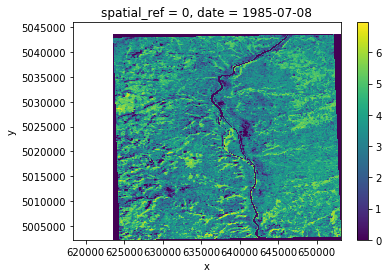

In [96]:
water_year_arrs[0][0].plot.imshow()

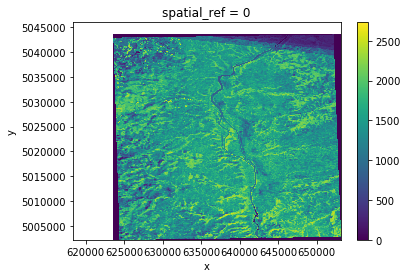

In [98]:
water_year_arrs[0].integrate(dim="date", datetime_unit="D").plot.imshow()

In [1]:
all_eeflux_arr.groupby(????????).integrate(dim="date", datetime_unit="D")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 55, 'height': 89, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",3],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",44],PARAMETER["false_easting",700000],PARAMETER["false_northing",6600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(3940.0, 0.0, 752344.6729321405,
       0.0, -5550.0, 6682060.744602234), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
49.8 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import pandas as pd
import numpy as np

labels = ['<=2', '3-9', '>=10']
bins = [0,2,9, np.inf]
pd.cut(all_eeflux_arr, bins, labels=labels)

In [41]:
all_eeflux_arr

<xarray.DataArray (date: 265, y: 1458, x: 1159)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 6.184e+05 6.184e+05 ... 6.531e+05 6.531e+05
  * y            (y) float64 5.002e+06 5.002e+06 ... 5.046e+06 5.046e+06
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 1985-04-03 1985-07-08 ... 2020-08-25
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [ ]:
import pandas as pd

all_scene_ids = [str(i) for i in list(all_scenes_f.glob("L*"))]
df = pd.DataFrame({"scene_id":all_scene_ids}).reindex()
split_vals_series = df.scene_id.str.split("/")

dff = pd.DataFrame(split_vals_series.to_list(), columns=['_', '__', '___', '____', '_____', '______', 'fname'])

df['date'] = dff['fname'].str.slice(10,18)

df['pathrow'] = dff['fname'].str.slice(4,10)

df['sensor'] = dff['fname'].str.slice(0,4)

df['datetime'] = pd.to_datetime(df['date'])

df = df.set_index("datetime").sort_index()

In [ ]:
marc_df = df['2014-01-01':'2019-12-31']

In [ ]:
marc_df = marc_df[marc_df['sensor']=="LC08"]

In [ ]:

x.where(x != badvalue).sel(band=1).plot.imshow()